In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import torch
import time

import programs.NN as NN
import programs.visualize as vis
import programs.misc as misc
import programs.objects as obj

from programs.Poisson_Convection import *
from programs.misc import *

In [2]:
torch.manual_seed(1234)
np.random.seed(1234)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device='cpu'
torch.cuda.set_device(device)
print(device)

cuda:0


In [3]:
# Ширина трещины
w = 0.5

# Вязкость
mu0 = 0.01

# Максимальная концентрация проппанта
cmax = 1.

# Концентрация входящего проппанта в первый момент времени
c1 = 0.5

# Концентрация входящего проппанта во второй момент времени
c2 = 0.0

# Интервалы смены концентрации
transitional_times = [0.5]

# Скорость потока
u_in = 1.

# Длина интервала перфорации
chi = 0.4

# Степень в вязкости
beta = -2.5

# Число точек для ГУ (возводится в квадрат)
BC_points = 64

# Число точек для НУ (возводится в квадрат)
IC_points = 64

# Число точек коллокации (возводится в куб)
PDE_points = 32

# Границы для x,y,t
x_min, x_max, y_min, y_max, t_min, t_max = 0.0, 1.0, 0.0, 1.0, 0.0, 1.0
boundaries = [x_min, x_max, y_min, y_max, t_min, t_max]

# Массивы условий
cond = u_in * -12
mu1 = cond * misc.viscosity(mu0,c1,cmax,beta)
mu2 = cond * misc.viscosity(mu0,c2,cmax,beta)
c_condition = [c1, c2]
print (cond*mu0/w**2, misc.viscosity(mu0,np.array(c_condition),cmax,beta))
print (misc.compare_viscosity(c1,c2,cmax,beta))

-0.48 [0.05656854 0.01      ]
5.656854249492381


In [4]:
net = Poisson_Convection({'w':w,
                          'mu0':mu0,
                          'cmax':cmax,
                          'u_in':u_in,
                          'chi':chi,
                          'times':transitional_times,
                          'size':boundaries,
                          'c_cond':c_condition,
                          'PDE_points':PDE_points,
                          'BC_points':BC_points,
                          'IC_points':IC_points,
                          'beta':beta,
                          'adaptive_freq' : 1001.1,
                          'NN_params' : {'input_size' : 3,
                                         # 'neurons_arr': [64, 64, 128, 256, 128, 64, 64],
                                         'neurons_arr': [48,48,48,48,48],
                                         # 'neurons_arr': [48]*20,
                                         'output_size' : 3,
                                         'depth' : 4,
                                        
                                        }
                          })
net.model.apply(NN.Net.init_weights)

Net(
  (layers): Sequential(
    (input): Linear(in_features=3, out_features=48, bias=True)
    (input_activation): Sin()
    (hidden_0): Linear(in_features=48, out_features=48, bias=True)
    (activation_0): Sin()
    (hidden_1): Linear(in_features=48, out_features=48, bias=True)
    (activation_1): Sin()
    (hidden_2): Linear(in_features=48, out_features=48, bias=True)
    (activation_2): Sin()
    (hidden_3): Linear(in_features=48, out_features=48, bias=True)
    (activation_3): Sin()
    (output): Linear(in_features=48, out_features=3, bias=True)
  )
)

In [5]:
# plt.scatter(net.x_IC.data.cpu(),net.y_IC.data.cpu(),c=net.c_IC.data.cpu())
# plt.scatter(net.x_IC.data.cpu(),net.y_IC.data.cpu(),c=misc.psi(net.x_IC.data.cpu(), net.chi, 1)*misc.psi(net.y_IC.data.cpu(), net.chi, 1))
# plt.colorbar()

(tensor(1.4999, device='cuda:0'), tensor(0.0556, device='cuda:0'))

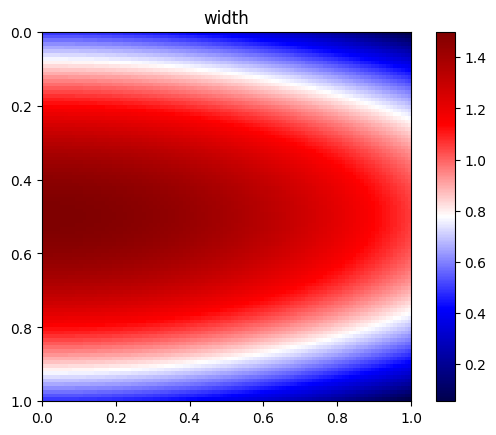

In [6]:
net.update_width(func_name='elliptic', w=1.5, w1=-1, w2=1.5, w3=0.5, w4=0.5)
net.make_distributed_points()
x = torch.linspace(0,1,100)
y = torch.linspace(0,1,100)
x, y = torch.meshgrid(x,y, indexing='ij')
plt.imshow(net.w_func(x,y).cpu().T, extent=[0,1,1,0], cmap='seismic')
plt.title('width')
# plt.clim(0,2)
plt.colorbar()
net.w_func(x,y).max(), net.w_func(x,y).min()

In [7]:
net.load("data/test_make")
# net.save("data/test_make")
# net.load('22315')
# vars(net)
# a = misc.psi(net.y_IC, net.chi)*torch.where(net.x_IC==0, 1, 0)
# for i in range(len(net.c_IC)):
    # if round(net.x_IC[i].item(),4)==0.0:
        # print ('-'*50)
    # print (i+1, round(net.c_IC[i].item(),4), round(net.x_IC[i].item(),4), round(net.y_IC[i].item(),4), round(net.t_IC[i].item(),4))
    # print (i+1, round(net.c_IC[i].item(),4), round(a[i].item(),4), round(net.x_IC[i].item(),4), round(net.y_IC[i].item(),4), round(net.t_IC[i].item(),4))

# for i in range(len(net.c)):
    # print (i+1, net.c[i].item(), net.p[i].item(), round(net.x_BC[i].item(), 4), round(net.y_BC[i].item(),4))#, round(net.t_BC[i].item(),4))

# for i in range(len(net.X)):
    # print (i+1,  round(cc[i].item(),4), round(net.X[i].item(), 4), round(net.Y[i].item(),4), round(net.T[i].item(),4))
# for i in range(len(net.c)):
    # print (i+1, net.X[i].item(),net.x_IC[i].item())

In [8]:
# net.load('data/with_w')

In [ ]:
# print (net.weights)
net.weights = [1, 1, 5, 5, 5, 5, 1]
net.Adam_epochs = 1000
start_time = time.time()
# for i in range(10):
# net.BC_coords()
# net.max_epoch=120000
net.train()
# net.save('data/with_w')
# net.save(f'data/CL_u_in/{u_in}')
# w = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05,0.01]
# uin = [1.5,2,2.5,3,3.5,4]
# for i in uin:
    # net.update_width('const',i)
    # net.make_distributed_points()
    # net.epoch = 0
    # net.train()
    # net.save(f'data/CL_u_in/{i}')
# net.save("data/att1.7")
# net.save('data/zerobeta2')
# net.save("data/0.6-0.2-0.0")
end_time = time.time()
elapsed_time = end_time - start_time

In [10]:
try:
    print('Elapsed time: ', elapsed_time)
except NameError: pass

Elapsed time:  2746.3751986026764


0.02470443770289421 50581


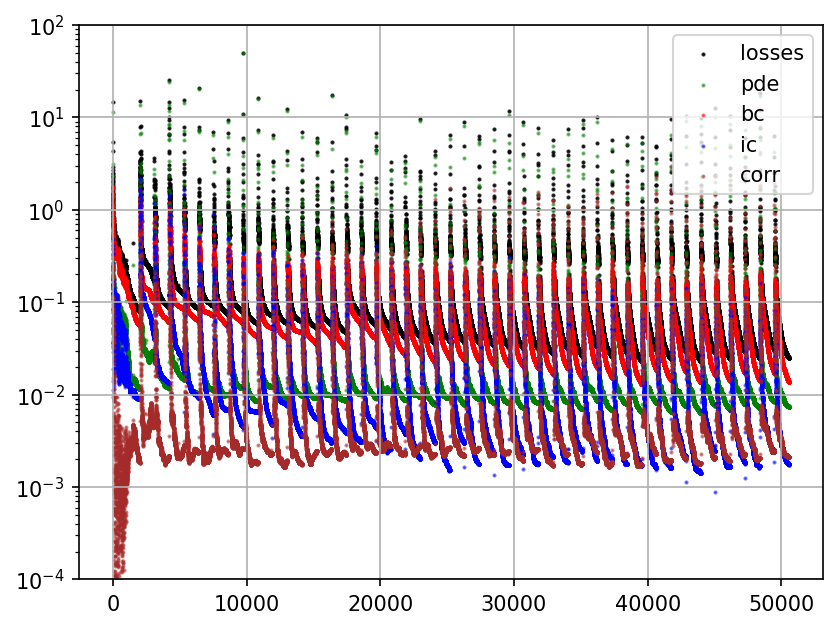

In [8]:
print (net.losses[-1], len(net.losses))
fig = plt.figure(dpi=150)
plt.scatter(range(0,len(net.losses)), net.losses,label='losses', c='black',alpha=0.8, s=1)
plt.scatter(range(0,len(net.PDE)), net.PDE,label='pde', c='green',alpha=0.5, s=1)
plt.scatter(range(0,len(net.BC)), net.BC, label='bc', c='red',alpha=0.5, s=1)
plt.scatter(range(0,len(net.IC)), net.IC, label='ic', c='blue',alpha=0.5, s=1)
plt.scatter(range(0,len(net.corr)), net.corr, label='corr', c='brown',alpha=0.5, s=1)
plt.legend(loc='upper right')
plt.grid()
# plt.savefig("gifs/losses")
plt.ylim(1e-4,100)
plt.yscale('log')

In [37]:
Nx = 501
Ny = 501
Nt = 501

x_Tensor = torch.linspace(net.size[0], net.size[1], Nx)
y_Tensor = torch.linspace(net.size[2], net.size[3], Ny)
t_Tensor = torch.linspace(net.size[4], net.size[5], Nt)

x = np.linspace(net.size[0], net.size[1], Nx)
y = np.linspace(net.size[2], net.size[3], Ny)
t = np.linspace(net.size[4], net.size[5], Nt)

mesh_x, mesh_y = np.meshgrid(x,y, indexing='ij')

In [65]:
net.eval()

c, px, py, ux, uy, mu, conv, div = [], [], [], [], [], [], [], []

for i in t_Tensor:
    mesh_XYT = torch.stack(torch.meshgrid(x_Tensor,y_Tensor,i, indexing='ij')).reshape(3, -1).T
    X = torch.autograd.Variable(mesh_XYT[:,0], requires_grad=True)#.reshape(-1,1)
    Y = torch.autograd.Variable(mesh_XYT[:,1], requires_grad=True)#.reshape(-1,1)
    T = torch.autograd.Variable(mesh_XYT[:,2], requires_grad=True)#.reshape(-1,1)

    c.append(net.get_c(X,Y,T).reshape(Nx, Ny).transpose(1,0))
    # px.append(net.get_px(X,Y,T).reshape(Nx, Ny).transpose(1,0))
    # py.append(net.get_py(X,Y,T).reshape(Nx, Ny).transpose(1,0))
    ux.append(net.get_ux(X,Y,T).reshape(Nx, Ny).transpose(1,0))
    uy.append(net.get_uy(X,Y,T).reshape(Nx, Ny).transpose(1,0))
    # conv.append(net.get_conv(X,Y,T).reshape(Nx, Ny).transpose(1,0))
    # div.append(net.get_div(X,Y,T).reshape(Nx, Ny).transpose(1,0))

c = np.array(c)
# px = np.array(px)
# py = np.array(py)
ux = np.array(ux)
uy = np.array(uy)
# conv = np.array(conv)
# div = np.array(div)

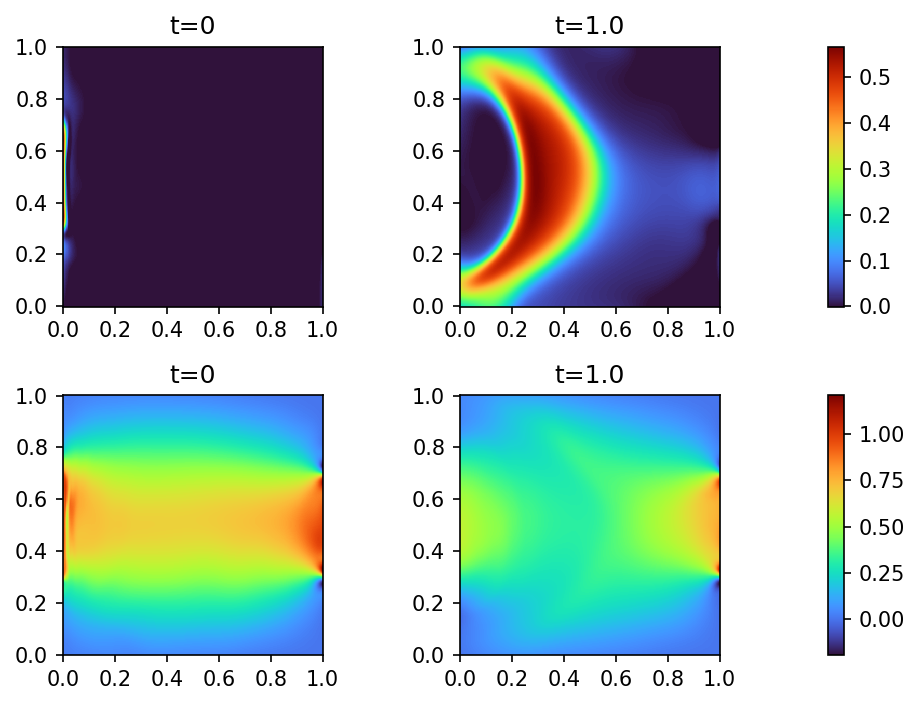

In [66]:
vis.plot_results([c[0],c[-1],ux[0],ux[-1]],[x_min, x_max, y_min, y_max], t_max, Nx, Ny)

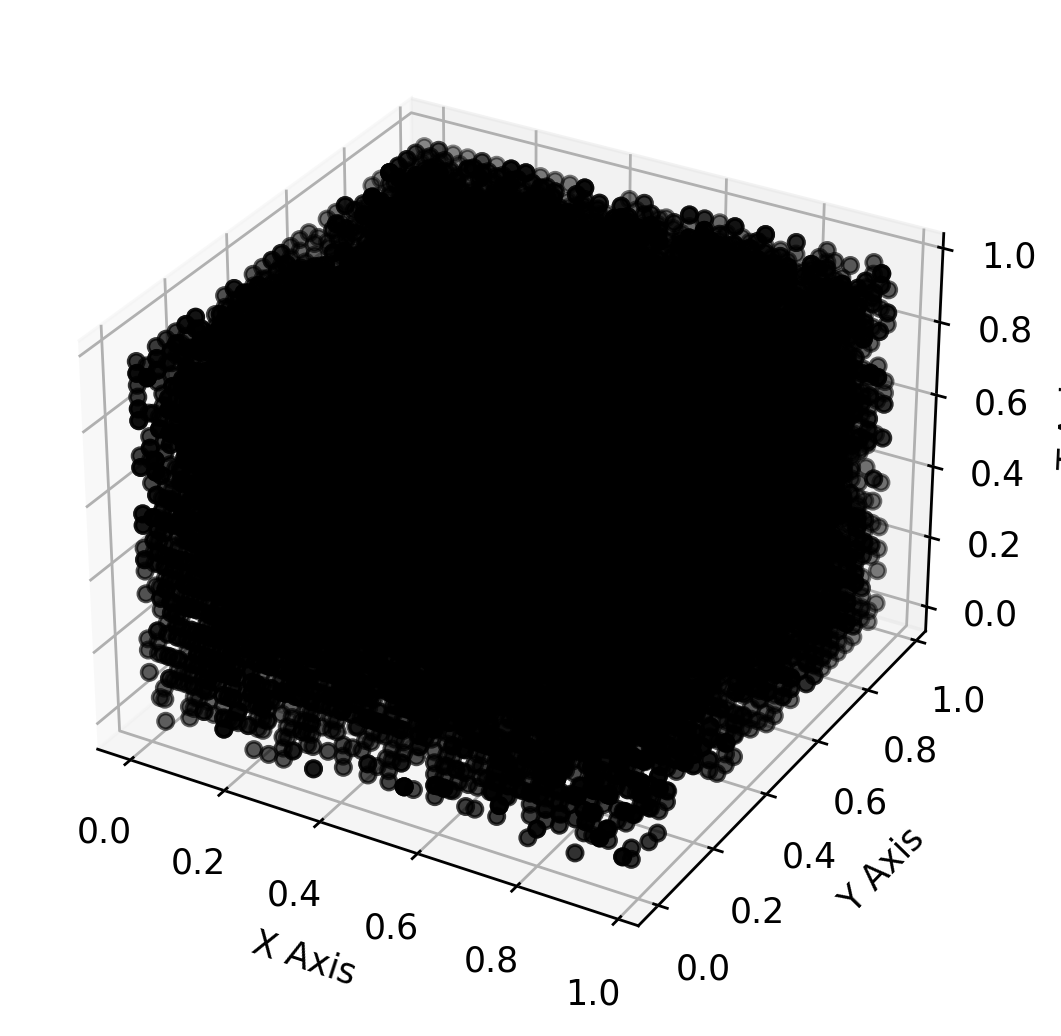

In [70]:
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D scatter plot
fig = plt.figure(figsize=(15,5),dpi=250)
ax = fig.add_subplot(111, projection='3d')
dots = ax.scatter(net.X.data.cpu(), net.Y.data.cpu(), net.T.data.cpu(),c='black', marker='o')
# fig.colorbar(dots)
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('T Axis')
pass

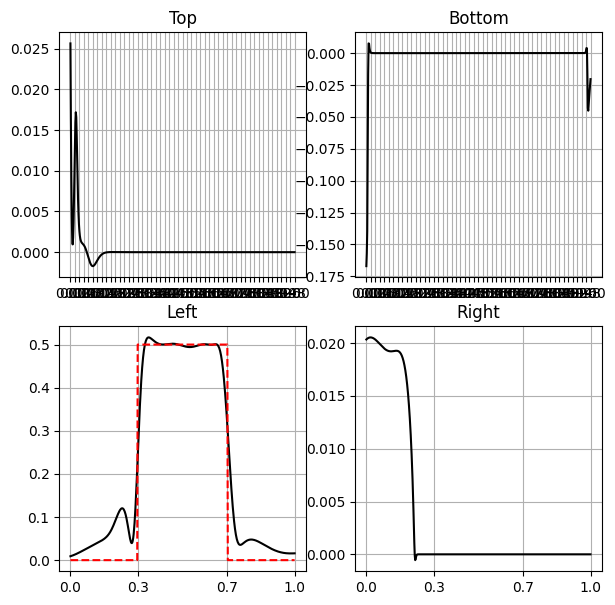

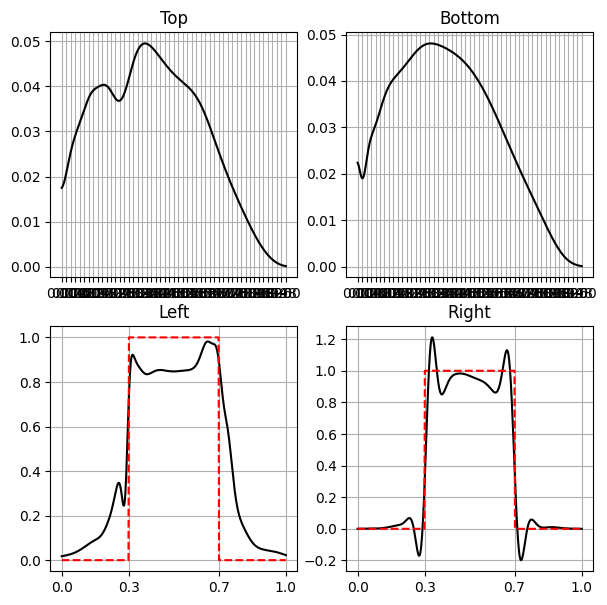

In [71]:
i = 0
vis.plot_BC(c[i], x, y, 1/(Nx-1), 1/(Ny-1), [1,1,0,0])
plt.subplot(223)
plt.plot(y, np.where(np.abs(y - np.max(y) / 2).round(4) <= chi / 2, c1, 0), c='red', ls='--')
# plt.plot(y, np.where(np.abs(y - np.max(y) / 2) <= chi / 2, c2, 0), c='red', ls='--')
plt.xticks([0, (np.max(y)-chi)/2, (np.max(y)+chi)/2 ,1])
plt.subplot(224)
plt.xticks([0, (np.max(y)-chi)/2, (np.max(y)+chi)/2 ,1])

# vis.plot_BC(px[i], x, y, 1/(Nx-1), 1/(Ny-1), [0,0,0,0])
# plt.subplot(223)
# plt.plot(y, np.where(np.abs(y - np.max(y) / 2).round(4) <= chi / 2, net.u.unique()[0].item(), 0), c='red', ls='--')
# plt.xticks([0, (np.max(y)-chi)/2, (np.max(y)+chi)/2 ,1])
# plt.subplot(224)
# plt.plot(y, np.where(np.abs(y - np.max(y) / 2).round(4) <= chi / 2, net.u.unique()[1].item(), 0), c='red', ls='--')
# plt.xticks([0, (np.max(y)-chi)/2, (np.max(y)+chi)/2 ,1])

vis.plot_BC(ux[i], x, y, 1/(Nx-1), 1/(Ny-1), [0,0,0,0])
plt.subplot(223)
plt.plot(y, np.where(np.abs(y - np.max(y) / 2).round(4) <= chi / 2, net.u_in, 0), c='red', ls='--')
plt.xticks([0, (np.max(y)-chi)/2, (np.max(y)+chi)/2 ,1])
plt.subplot(224)
plt.plot(y, np.where(np.abs(y - np.max(y) / 2).round(4) <= chi / 2, net.u_in, 0), c='red', ls='--')
plt.xticks([0, (np.max(y)-chi)/2, (np.max(y)+chi)/2 ,1])
pass

Frame: t = 0.0s


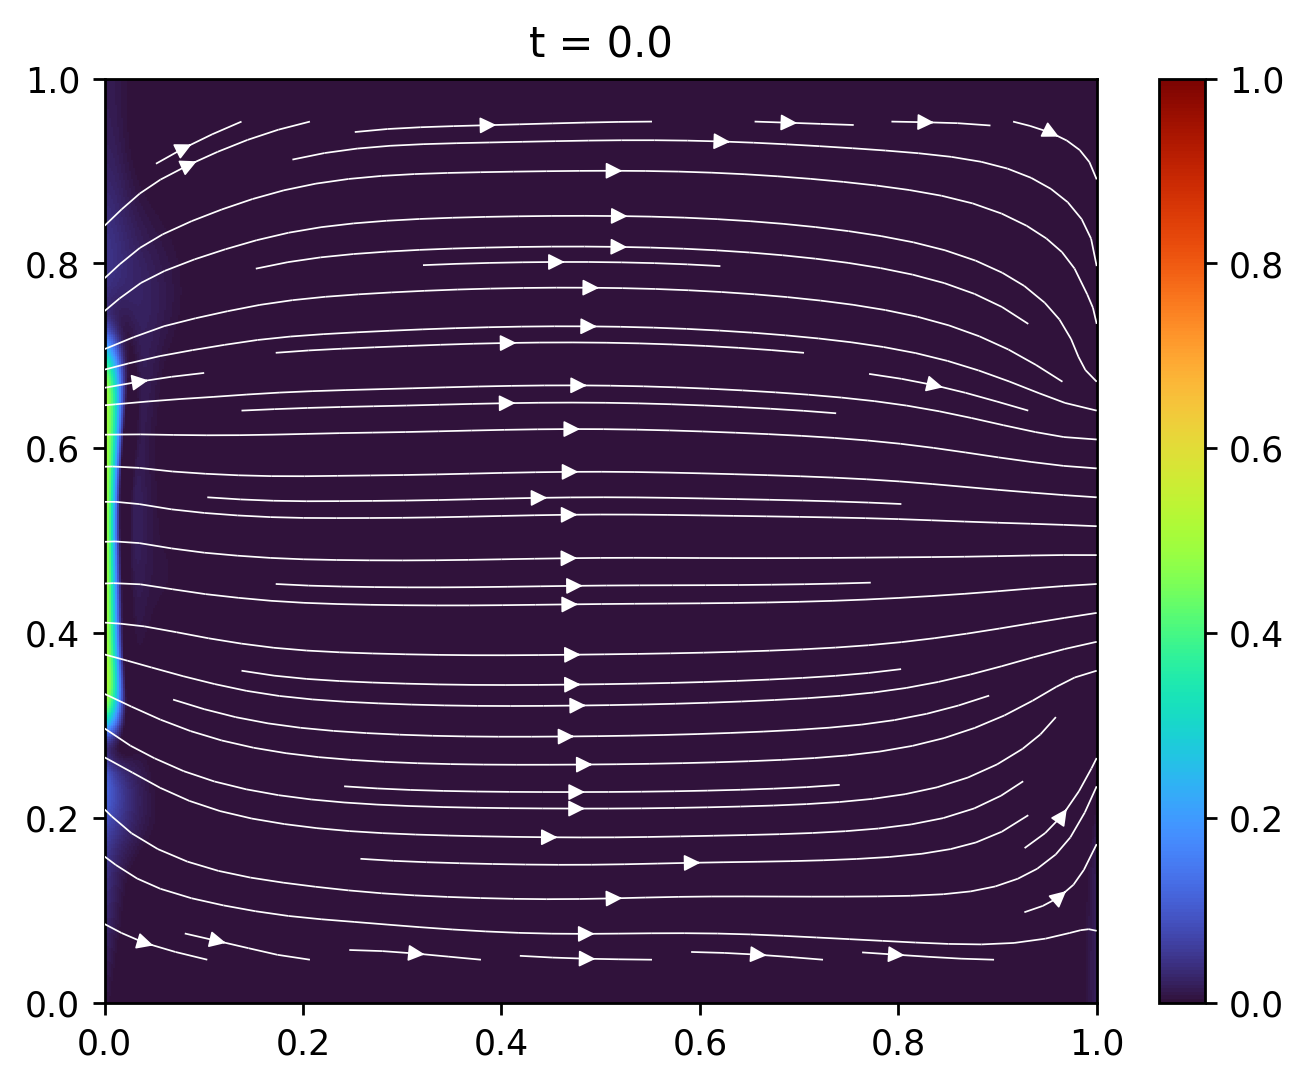

In [72]:
fig, ax = plt.subplots()
fig.dpi = 250
i = 0
print(f'Frame: t = {t[i]}s') 

#Plot frame
imsh = ax.imshow(c[i], cmap = 'turbo', extent = [0, 1, 1, 0], interpolation='none', aspect='auto')
# imsh = ax.imshow((np.abs(conv)+np.abs(div))[i], cmap = 'turbo', extent = [0, 1, 1, 0], interpolation='none', aspect='auto')
plt.gca().invert_yaxis()
plt.colorbar(imsh)
imsh.set_clim(0,1)

#Plot training points
# j = 0
# mask = (net.T.data.cpu().numpy() == np.unique(net.T.data.cpu().numpy())[j])
# ax.scatter(net.X.data.cpu()[mask], net.Y.data.cpu().numpy()[mask], c='black', alpha=0.2)

#Plot velocity streamlines
ax1 = ax.twinx()
strm = ax1.streamplot(mesh_y, mesh_x, ux[i], uy[i], linewidth=0.5, color='white')
ax1.axis('off')
# fig.colorbar(strm.lines)

plt.title(f't = {t[i]}')
pass

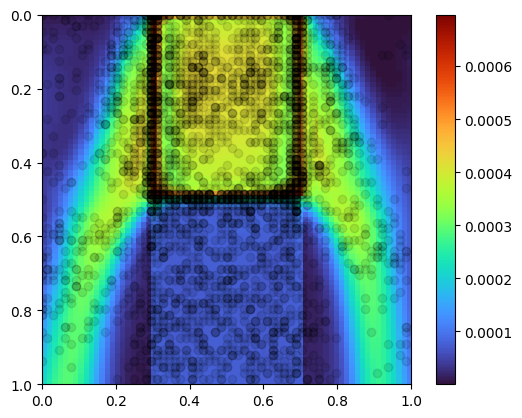

In [30]:
#Plot training points on boundaries

# net.make_distributed_points()

# RIGHT BOUNDARY
# plt.scatter(net.y_BC[3*net.BC_points2:].data.cpu(), net.t_BC[3*net.BC_points2:].data.cpu(),alpha=0.2,c='black')
plt.scatter(net.y_BC[2*net.BC_points2:3*net.BC_points2].data.cpu(), net.t_BC[2*net.BC_points2:3*net.BC_points2].data.cpu(),
            alpha=0.1, c='black')#c=net.p[2*net.BC_points2:3*net.BC_points2].abs().data.cpu(),)

# LEFT BOUNDARY
# plt.imshow(np.abs(1*px[:,-1,:]-0*np.where(np.abs(mesh_y-1/2)<=net.chi/2,-1,0)*12*mu0),extent=[0,1,1,0],cmap='turbo')
pres = np.abs(1*px[:,:,0]-1*(np.where(np.abs(mesh_y-1/2)<=net.chi/2,-1,0)*12*(np.where(t<0.5,1,0)*misc.viscosity(mu0,0.5,1)+1*np.where(t>=0.5,1,1)*mu0)).T)
conc = np.abs(1*c[:,:,0] - 1*(np.where(np.abs(mesh_y-1/2)<=net.chi/2,1,0) * 0.5*np.where(t<0.5,1,0)).T)
plt.imshow((conc+pres)/np.sum(conc+pres), extent=[0,1,1,0],cmap='turbo')
plt.colorbar()

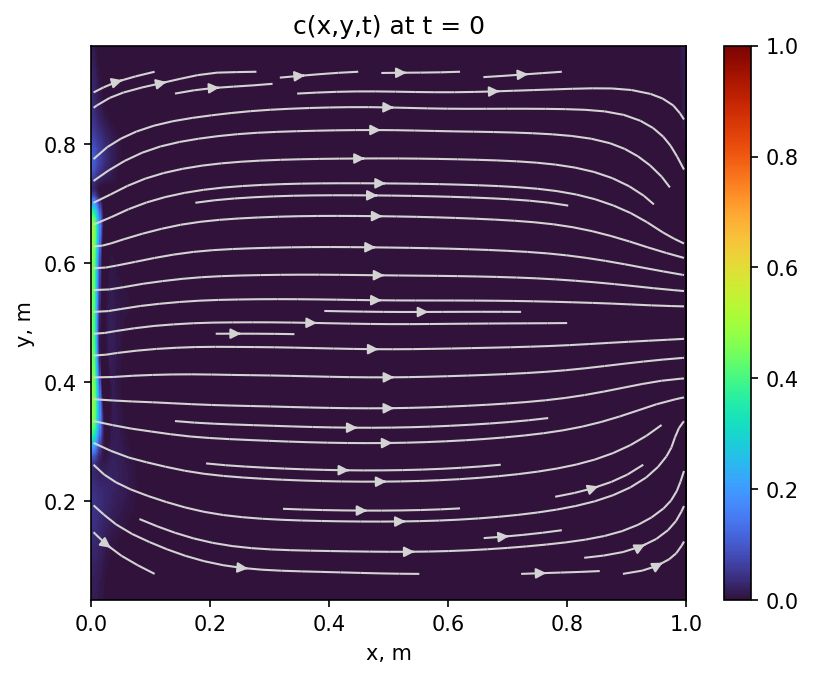

In [74]:
vis.anim_result(c,
                t_max/Nt,
                clims=[0,1],
                streamplot_data=[mesh_y[2:-2,2:-2],mesh_x[2:-2,2:-2],ux[:,2:-2,2:-2],uy[:,2:-2,2:-2]],
                name='serv_test',
                title='c(x,y,t)',
                colour='turbo',
                path='gifs',
                savetogif=True,
                showMe=True,
                )